In [1]:
import os
import sys
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)

import numpy as np
from data import Dataset

DATA_DIR = "../data/Problem_01"
RESULT_DIR = "../results/Problem_01"

dataset = Dataset(DATA_DIR, RESULT_DIR, fps=5)

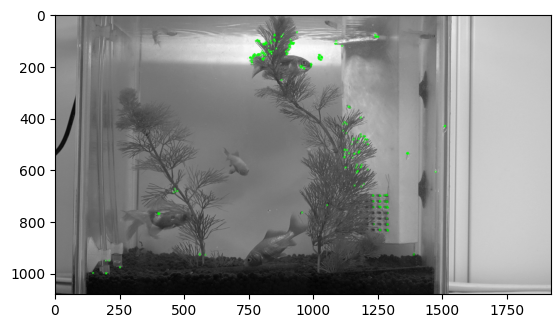

In [2]:
import cv2
import matplotlib.pyplot as plt

imgs = dataset.get_images([0, 1, 2])

# ax1 = plt.subplot(1,2,1)
# ax2 = plt.subplot(1, 2, 2)
# ax1.imshow(imgs[0])
# ax2.imshow(imgs[1])

# グレースケールにしてコーナ特徴点を抽出
prev_frame = imgs[0]
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_RGB2GRAY)

orb = cv2.ORB_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = orb.detectAndCompute(prev_gray,None)
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.

img2 = cv2.drawKeypoints(prev_gray, kp1, None, color=(0,255,0), flags=0)
plt.imshow(img2)